In [1]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pyplot import plot, ion, show, savefig, cla, figure
import random
import time

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
from data_loader import DataGenerator
from models import VAEmodel, lstmKerasModel
from trainers import vaeTrainer

from utils import process_config, create_dirs, get_args

In [4]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_available_gpus())

[]


In [5]:
# load VAE model
config = process_config('NAB_config4_centralized.json')#('NAB_config_centralized.json')
# create the experiments dirs
create_dirs([config['result_dir'], config['checkpoint_dir']])
# create tensorflow session
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# create your data generator

data = DataGenerator(config)
# create a CNN model
model_vae = VAEmodel(config, "Centralized")
# create a CNN model
trainer_vae = vaeTrainer(sess, model_vae, data, config)
model_vae.load(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device

ECG
ECG
ECG
ECG
ECG
ECG
ECG
ECG
ECG



original_signal shape:  (?, 24, 2)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

input_tensor shape: (?, 24, 2, 1)
Instruction

Reach the definition of loss for VAE



checkpoint_dir at loading: ../experiments/local-results/ECG/ecg/batch-32/ECG-ecg-24-12-6-fixedSigma-0.1/checkpoint/Centralized
Loading model checkpoint ../experiments/local-results/ECG/ecg/batch-32/ECG-ecg-24-12-6-fixedSigma-0.1/checkpoint/Centralized/-1320 ...

INFO:tensorflow:Restoring parameters from ../experiments/local-results/ECG/ecg/batch-32/ECG-ecg-24-12-6-fixedSigma-0.1/checkpoint/Centralized/-1320
Model loaded.


In [6]:
print(data.__dict__.keys())
for i in data.__dict__.keys():
    if (i not in ['config','train_set_vae','val_set_vae','test_set_vae','train_set_lstm', 'val_set_lstm']):
        print(i ,getattr(data,i))
for i in  ['train_set_vae','val_set_vae','test_set_vae','train_set_lstm', 'val_set_lstm']:
    print(i ,(getattr(data,i)['data']).shape)




dict_keys(['config', 'n_train_vae', 'n_val_vae', 'train_set_vae', 'val_set_vae', 'test_set_vae', 'n_train_lstm', 'n_val_lstm', 'train_set_lstm', 'val_set_lstm'])
n_train_vae 2174
n_val_vae 242
n_train_lstm 1936
n_val_lstm 216
train_set_vae (2174, 24, 2)
val_set_vae (242, 24, 2)
test_set_vae (32, 24, 2)
train_set_lstm (1936, 12, 24, 2)
val_set_lstm (216, 12, 24, 2)


In [7]:
config['dataset']

'ecg_2'

In [6]:
# load LSTM model
lstm_model = lstmKerasModel("Centralized", config)
lstm_model.produce_embeddings(model_vae, data, sess)
lstm_nn_model = lstm_model.create_lstm_model()
lstm_nn_model.summary()   # Display the model's architecture

# checkpoint path
checkpoint_path = config['checkpoint_dir_lstm'] + "cp_Centralized.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
# load weights if possible
lstm_model.load_model(lstm_nn_model, checkpoint_path)

lstm input: (?, 11, 6)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Finish processing the embeddings of the entire dataset of Centralized.
lstm input: (?, 11, 6)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 11, 6)]           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 11, 64)            18176     
_________________________________________________________________
lstm_4 (LSTM)                (None, 11, 64)            33024     
_________________________________________________________________
lstm_5 (LSTM)                (None, 11, 6)             1704      
Total params: 52,904
Trainable params: 52,904
Non-trainable params: 0
_________________________________________________________________
../experiments/local-results/ECG/ecg/batch-32/ECG-ecg-2

In [91]:
# load normalised time series
save_dir = '../datasets/NAB-known-anomaly/'
config['dataset'] = 'ecg_9'
dataset = config['dataset']
filename = '{}.npz'.format(dataset)
result = dict(np.load(save_dir+filename, allow_pickle=True))
if dataset == 'machine_temp':
    result['test'] = result['test'][0]
    result['idx_anomaly_test'] = result['idx_anomaly_test'][0]
    result['t_test'] = result['t_test'][0]

# slice into rolling windows and rolling sequences
# slice into rolling windows and rolling sequences
def slice_rolling_windows_and_sequences(config, time_seq):
    n_sample = len(time_seq)
    time_seq = np.reshape(time_seq,(-1,config['n_channel']))
    print("The given sequence has {} samples".format(n_sample))
    n_vae_win = n_sample - config['l_win'] + 1
    rolling_windows = np.zeros((n_vae_win, config['l_win'], config['n_channel']))
    for i in range(n_vae_win):
        rolling_windows[i] = time_seq[i:i + config['l_win']]
        sample_m = np.mean(rolling_windows, axis=1)
        sample_std = np.std(rolling_windows, axis=1)

        n_lstm_seq = n_sample - config['l_seq']*config['l_win']+1
        lstm_seq = np.zeros((n_lstm_seq, config['l_seq'], config['l_win'], config['n_channel']))
    for i in range(n_lstm_seq):
        cur_seq = time_seq[i:i+config['l_seq']*config['l_win']]
        for j in range(config['l_seq']):
            lstm_seq[i,j] = cur_seq[config['l_win']*j:config['l_win']*(j+1)]
    
    return rolling_windows, lstm_seq, sample_m, sample_std

test_windows, test_seq, test_sample_m, test_sample_std = slice_rolling_windows_and_sequences(config, result['test'])
test_windows = np.reshape(test_windows, (-1,config['l_win'],config['n_channel']))
test_seq = np.reshape(test_seq, (-1,config['l_seq'],config['l_win'],config['n_channel']))
print('test_windows ',test_windows.shape)
print('test_seq ',test_seq.shape)

The given sequence has 1756 samples
test_windows  (1733, 24, 2)
test_seq  (1469, 12, 24, 2)


In [92]:
result


{'readings': array([[4.995, 4.34 ],
        [4.995, 4.34 ],
        [4.995, 4.34 ],
        ...,
        [4.985, 5.575],
        [4.995, 5.575],
        [5.015, 5.595]]),
 'idx_anomaly': array([4021, 4022, 4023, 4024, 4025, 4026, 4027, 4028, 4029, 4030, 4031,
        4032, 4033, 4034, 4035, 4036, 4037, 4038, 4039, 4040, 4041, 4042,
        4043, 4044, 4045, 4046, 4047, 4048, 4049, 4050, 4051, 4052, 4053,
        4054, 4055, 4056, 4057, 4058, 4059, 4060, 4061, 4062, 4063, 4064,
        4065, 4066, 4067, 4068, 4069, 4070, 4071, 4072, 4073, 4074, 4075,
        4076, 4077, 4078, 4079, 4080, 4081, 4082, 4083, 4084, 4085, 4086,
        4087, 4088, 4089, 4090, 4091, 4092, 4093, 4094, 4095, 4096, 4097,
        4098, 4099, 4100, 4101, 4102, 4103, 4104, 4105, 4106, 4107, 4108,
        4109, 4110, 4111, 4112, 4113, 4114, 4115, 4116, 4117, 4118, 4119,
        4120, 4121, 4122, 4123, 4124, 4125, 4126, 4127, 4128, 4129, 4130,
        4131, 4132, 4133, 4134, 4135, 4136, 4137, 4138, 4139, 4140, 4141,


In [ ]:
# Evaluate ELBO and LSTM prediction error on the validation set
# evaluate some anomaly detection metrics
def evaluate_vae_anomaly_metrics_for_a_window(test_win):
    feed_dict = {model_vae.original_signal: np.expand_dims(test_win, 0),
                 model_vae.is_code_input: False,
                 model_vae.code_input: np.zeros((1, config['code_size']))}

    # VAE reconstruction error
    recons_win_vae = np.squeeze(sess.run(model_vae.decoded, feed_dict=feed_dict))
    test_vae_recons_error = np.sum(np.square(recons_win_vae - test_win))

    # VAE latent embedding likelihood
    vae_code_mean, vae_code_std = sess.run([model_vae.code_mean, model_vae.code_std_dev], feed_dict=feed_dict)
    test_vae_kl = 0.5 * (np.sum(np.square(vae_code_mean)) + \
                            np.sum(np.square(vae_code_std)) - \
                            np.sum(np.log(np.square(vae_code_std))) - config['code_size'])

    # VAE ELBO loss
    sigma2 = 0.0005
    input_dims = model_vae.input_dims
    sigma_regularisor = input_dims/2. * np.log(sigma2) + input_dims * np.pi
    test_vae_elbo = test_vae_recons_error/sigma2 + test_vae_kl + sigma_regularisor
    return test_vae_recons_error, test_vae_kl, test_vae_elbo

def evaluate_lstm_anomaly_metric_for_a_seq(test_seq):
    feed_dict = {model_vae.original_signal: test_seq,
                 model_vae.is_code_input: False,
                 model_vae.code_input: np.zeros((1, config['code_size']))}
    vae_embedding = np.squeeze(sess.run(model_vae.code_mean, feed_dict=feed_dict))
    #print(vae_embedding.shape)
    lstm_embedding = np.squeeze(lstm_nn_model.predict(np.expand_dims(vae_embedding[:config['l_seq']-1], 0), batch_size=1))
    lstm_embedding_error = np.sum(np.square(vae_embedding[1:] - lstm_embedding))
    # error_original = vae_embedding[1:] - lstm_embedding
    #print(error_original.shape)
    
    # LSTM prediction error
    feed_dict_lstm = {model_vae.original_signal: np.zeros((config['l_seq'] - 1, config['l_win'], config['n_channel'])),
                      model_vae.is_code_input: True,
                      model_vae.code_input: lstm_embedding}
    recons_win_lstm = np.squeeze(sess.run(model_vae.decoded, feed_dict=feed_dict_lstm))
    lstm_recons_error = np.sum(np.square(recons_win_lstm - np.squeeze(test_seq[1:])))
    error_original = np.abs(recons_win_lstm - np.squeeze(test_seq[1:])).reshape((config['l_seq']-1,-1)) #them dong nay de tinh
    return lstm_recons_error, lstm_embedding_error, error_original
data.val_set_vae['data'] = np.asarray(data.val_set_vae['data'])
data.val_set_lstm['data'] = np.asarray(data.val_set_lstm['data'])
data.train_set_lstm['data'] = np.asarray(data.train_set_lstm['data'])
data.train_set_vae['data'] = np.asarray(data.train_set_vae['data'])
n_val_vae = data.val_set_vae['data'].shape[0]
n_val_lstm = data.val_set_lstm['data'].shape[0]

val_vae_recons_error = np.zeros(n_val_vae)
val_vae_kl_error = np.zeros(n_val_vae)
val_vae_elbo_loss = np.zeros(n_val_vae)
for i in range(n_val_vae):
    val_vae_recons_error[i], val_vae_kl_error[i], val_vae_elbo_loss[i] = evaluate_vae_anomaly_metrics_for_a_window(data.val_set_vae['data'][i])

val_lstm_recons_error, val_lstm_embedding_error = np.zeros(n_val_lstm), np.zeros(n_val_lstm)
val_lstm_error_original = np.zeros((n_val_lstm,config['l_seq']-1,config['l_win']*config['n_channel']))
for i in range(n_val_lstm):
    val_lstm_recons_error[i], val_lstm_embedding_error[i], val_lstm_error_original[i] = evaluate_lstm_anomaly_metric_for_a_seq(data.val_set_lstm['data'][i])
    
n_train_lstm = data.train_set_lstm['data'].shape[0]
train_lstm_recons_error, train_lstm_embedding_error = np.zeros(n_train_lstm), np.zeros(n_train_lstm)
train_lstm_error_original = np.zeros((n_train_lstm,config['l_seq']-1,config['l_win']*config['n_channel'])) #them de tinh OCSVM
for i in range(n_train_lstm):
    train_lstm_recons_error[i], train_lstm_embedding_error[i], train_lstm_error_original[i] = evaluate_lstm_anomaly_metric_for_a_seq(data.train_set_lstm['data'][i])

In [ ]:
config['l_seq']

In [ ]:
from scipy.stats import norm
def plot_histogram(test_anomaly_metric, n_bins, title, mean=None, std=None, xlim=None, saveplot=False):
    test_anomaly_list = np.squeeze(np.ndarray.flatten(test_anomaly_metric))
    his = plt.hist(test_anomaly_list, bins=n_bins, density=True)
    if mean is None and std is None:
        mean = np.mean(test_anomaly_list)
        std = np.std(test_anomaly_list)
        legend_label = None
    else:
        legend_label = 1
    x_axis = np.arange(mean-5*std, mean+5*std, std/100)
    plt.plot(x_axis, norm.pdf(x_axis,mean,std))
    plt.title(title)
    plt.xlabel('anomaly score value')
    plt.ylabel('probability density')
    if xlim is not None:
        plt.xlim(0, xlim)
    else:
        plt.xlim(0, np.amax(test_anomaly_list))
    if legend_label is None:
        plt.legend(('Fitted Gaussian', 'histogram'))
    else:
        plt.legend(('normal data distribution','test data distribution (contain anomalies)'))
    if saveplot:
        savefig(config['result_dir']+'reconstruction_error_histogram.pdf')
    else:
        plt.show()
    threshold_25 = np.percentile(test_anomaly_list, 25)
    threshold_75 = np.percentile(test_anomaly_list, 75)
    threshold_1 = np.percentile(test_anomaly_list, 99)
    idx_large_error = np.squeeze(np.argwhere(test_anomaly_metric > threshold_1))
#     print(his[0][-20:])
#     print(his[1][-20:])
    print("25% percentile: {}".format(threshold_25))
    print("75% percentile: {}".format(threshold_75))
#     print("Median: {}".format(np.median(test_anomaly_list)))
#     print("Mean: {}".format(np.mean(test_anomaly_list)))
#     print("Std dev: {}".format(np.std(test_anomaly_list)))
    print("These windows scored the top 1% of anomaly metric ({}): \n{}".format(threshold_1, idx_large_error))
    return mean, std

In [ ]:
# Histogram of VAE ELBO loss - validation set
vae_elbo_m, vae_elbo_std = plot_histogram(val_vae_elbo_loss, 100, 
                                          'VAE ELBO error distribution on the val set', 
                                          mean=None, std=None, xlim=None)

In [ ]:
# Histogram of LSTM reconstruction error - train set 
#  --> to decide the anomaly detection threshold
lstm_recons_m_train, lstm_recons_std_train = plot_histogram(train_lstm_recons_error, 100,  
                                              'LSTM reconstruction error distribution on the train set', 
                                              mean=None, std=None, xlim=None)

In [ ]:
# Histogram of LSTM reconstruction error - validation set 
#  --> to decide the anomaly detection threshold
lstm_recons_m_val, lstm_recons_std_val = plot_histogram(val_lstm_recons_error, 100,  
                                              'LSTM reconstruction error distribution on the val set', 
                                              mean=None, std=None, xlim=None)

In [ ]:
# Evaluate the anomaly metrics on the test windows and sequences
n_test_lstm = test_seq.shape[0]

test_lstm_recons_error, test_lstm_embedding_error = np.zeros(n_test_lstm), np.zeros(n_test_lstm)
test_lstm_error_original = np.zeros((n_test_lstm,config['l_seq']-1,config['l_win']*config['n_channel']))
for i in range(n_test_lstm):
    test_lstm_recons_error[i], test_lstm_embedding_error[i], test_lstm_error_original[i] = evaluate_lstm_anomaly_metric_for_a_seq(test_seq[i])
print("All windows' reconstruction error is computed.")
print("The total number of windows is {}".format(len(test_lstm_recons_error)))

In [ ]:
# Histogram of LSTM reconstruction error - test set 
#  --> to detect anomaly now
_, _ = plot_histogram(test_lstm_recons_error, 100,
                      'LSTM reconstruction error distribution on the test set', 
                      mean=lstm_recons_m_val, std=lstm_recons_std_val, xlim=None, saveplot=True)

In [ ]:
# Produce the ground truth anomaly indices 
# if result['idx_split'][0] == 0:
#     idx_anomaly_test = result['idx_anomaly_test']
# else:
#     idx_anomaly_test = result['idx_anomaly_test'][0]
idx_anomaly_test = result['idx_anomaly_test']    
anomaly_index_lstm = []
test_labels_lstm = np.zeros(n_test_lstm)
for i in range(len(idx_anomaly_test)):
    idx_start = idx_anomaly_test[i]-(config['l_win']*config['l_seq']-1)
    idx_end = idx_anomaly_test[i]+1
    if idx_start < 0:
        idx_start = 0
    if idx_end > n_test_lstm:
        idx_end = n_test_lstm
    anomaly_index_lstm.append(np.arange(idx_start,idx_end))
    test_labels_lstm[idx_start:idx_end] = 1
    
print(test_labels_lstm.shape)

In [ ]:
print(result['idx_anomaly_test'])
print(list(anomaly_index_lstm))
print(test_labels_lstm)

In [ ]:
test_normal_idx = np.squeeze(np.argwhere(test_labels_lstm==0))
test_anomaly_idx = np.squeeze(np.argwhere(test_labels_lstm==1))
test_lstm_recons_error_normal = test_lstm_recons_error[test_normal_idx]
test_lstm_recons_error_anomaly = test_lstm_recons_error[test_anomaly_idx]
lstm_recons_m_test_normal = np.mean(test_lstm_recons_error_normal)
lstm_recons_std_test_normal = np.std(test_lstm_recons_error_normal)
lstm_recons_m_test_anomaly = np.mean(test_lstm_recons_error_anomaly)
lstm_recons_std_test_anomaly = np.std(test_lstm_recons_error_anomaly)
lstm_recons_m_test = np.mean(test_lstm_recons_error)
lstm_recons_std_test = np.std(test_lstm_recons_error)

means = (lstm_recons_m_test_normal, lstm_recons_m_test_anomaly, lstm_recons_m_test, lstm_recons_m_train, lstm_recons_m_val)
stds = (lstm_recons_std_test_normal, lstm_recons_std_test_anomaly, lstm_recons_std_test, lstm_recons_std_train, lstm_recons_std_val)
for mean,std in zip(means,stds):
    x_axis = np.arange(mean-5*std, mean+5*std, std/100)
    #x_axis = np.arange(-10000,10000)
    plt.plot(x_axis, norm.pdf(x_axis,mean,std))
plt.legend(('test_norm', 'test_anomaly', 'test', 'train', 'val')) 
#plt.xscale('log')
#plt.yscale('log')
plt.title("Distribution of different sets on " + config['dataset'])
#print(lstm_recons_m_test,lstm_recons_std_test)
#print(lstm_recons_m_val,lstm_recons_std_val)
#print(lstm_recons_m_test_normal,lstm_recons_m_test_normal)
print(means)
print(stds)

In [ ]:
def return_anomaly_idx_by_threshold(test_anomaly_metric, threshold):
    test_list = np.squeeze(np.ndarray.flatten(test_anomaly_metric))
    idx_error = np.squeeze(np.argwhere(test_anomaly_metric > threshold))
    
    if len(idx_error.shape) == 0:
        idx_error = np.expand_dims(idx_error, 0)
    
    return list(idx_error)

In [ ]:
def augment_detected_idx(idx_detected_anomaly, anomaly_index):
    n_anomaly = len(anomaly_index)
    idx_detected_anomaly_extended = list(idx_detected_anomaly)
    for i in range(n_anomaly):
        #print(idx_detected_anomaly)
        for j in idx_detected_anomaly:
            if j in anomaly_index[i]:
                in_original_detection = set(idx_detected_anomaly_extended)
                currect_anomaly_win = set(anomaly_index[i])
                idx_detected_anomaly_extended = idx_detected_anomaly_extended + list(currect_anomaly_win - in_original_detection)
                #print(j)
                break
                
    return list(np.sort(idx_detected_anomaly_extended))

In [ ]:
def count_TP_FP_FN(idx_detected_anomaly, anomaly_index, test_labels):
    n_TP = 0
    n_FP = 0
    n_detection = len(idx_detected_anomaly)
    for i in range(n_detection):
        if test_labels[idx_detected_anomaly[i]] == 1:
            n_TP = n_TP + 1
        else:
            n_FP = n_FP + 1 #both branch the same?
    
    idx_undetected = list(set(np.arange(len(test_labels)))- set(idx_detected_anomaly))
    n_FN = 0
    for i in idx_undetected:
        if test_labels[i] == 1:
            n_FN = n_FN + 1
    
    return n_TP, n_FP, n_FN

In [ ]:
def compute_precision_and_recall(idx_detected_anomaly, anomaly_index, test_labels):
    # compute true positive
    n_TP, n_FP, n_FN = count_TP_FP_FN(idx_detected_anomaly, anomaly_index, test_labels)
    
    if n_TP + n_FP == 0:
        precision = 1
    else:
        precision = n_TP / (n_TP + n_FP)
    recall = n_TP / (n_TP + n_FN)
    if precision + recall == 0:
        F1 = 0
    else:
        F1 = 2* (precision * recall)/(precision + recall)
    
    return precision, recall, F1, n_TP, n_FP, n_FN

In [ ]:
n_threshold = 25
precision = np.zeros(n_threshold)
recall = np.zeros(n_threshold)
F1 = np.zeros(n_threshold)
precision_aug = np.zeros(n_threshold)
recall_aug = np.zeros(n_threshold)
F1_aug = np.zeros(n_threshold)
i = 0
threshold_list = np.linspace(np.amin(test_lstm_recons_error), np.amax(test_lstm_recons_error), n_threshold, endpoint=True)
threshold_list = np.flip(threshold_list)
for threshold in threshold_list:
    #print(threshold_list[i])
    idx_detection_lstm = return_anomaly_idx_by_threshold(test_lstm_recons_error, threshold)
    precision[i], recall[i], F1[i], _, _, _ = compute_precision_and_recall(idx_detection_lstm, 
                                                                           anomaly_index_lstm, 
                                                                           test_labels_lstm)
    # augment the detection using the ground truth labels
    # a method to discount the factor one anomaly appears in multiple consecutive windows
    # introduced in "Unsupervised anomaly detection via variational auto-encoder for seasonal kpis in web applications"
    idx_detection_lstm_augmented = augment_detected_idx(idx_detection_lstm, anomaly_index_lstm)
    precision_aug[i], recall_aug[i], F1_aug[i], _, _, _ = compute_precision_and_recall(idx_detection_lstm_augmented, 
                                                                                       anomaly_index_lstm, 
                                                                                       test_labels_lstm)
    i = i + 1
    #print(precision, recall, F1)

In [ ]:
print("Best F1 score is {}".format(np.amax(F1)))
idx_best_threshold = np.squeeze(np.argwhere(F1 == np.amax(F1)))
print("Best threshold is {}".format(threshold_list[idx_best_threshold]))
print("At this threshold, precision is {}, recall is {}".format(precision[idx_best_threshold], recall[idx_best_threshold]))
average_precision = np.sum(precision[1:] * (recall[1:] - recall[:-1]))
print("Average precision is {}".format(average_precision))

print("\nAugmented detection:")
print("Best F1 score is {}".format(np.amax(F1_aug)))
idx_best_threshold = np.squeeze(np.argwhere(F1_aug == np.amax(F1_aug)))
print("Best threshold is {}".format(threshold_list[idx_best_threshold]))
best_thres = np.min(threshold_list[idx_best_threshold])
print("At this threshold, precision is {}, recall is {}".format(precision_aug[idx_best_threshold], 
                                                                recall_aug[idx_best_threshold]))

average_precision_aug = np.sum(precision_aug[1:] * (recall_aug[1:] - recall_aug[:-1]))
print("Average precision is {}".format(average_precision_aug))

In [ ]:
import math
from scipy.stats import norm

def KQp(data,q):
#UNTITLED3 Summary of this function goes here
#   Detailed explanation goes here
    data2 = np.sort(data) #sap xep tang dan
    n = np.shape(data2)[0] #kich thuoc
    p = 1-q #q tu xet, dat bang smth 0.05 0.025 0.01
    h = math.sqrt((p*q)/(n+1));
    KQ=0;
    for i in range(1,n+1):
        a= ((i/n)-p)/h;
        b= (((i-1)/n)-p)/h;
        TP=(norm.cdf(a)-norm.cdf(b))*data2[i-1]; #normcdf thu trong matlab
        KQ=KQ+TP;    
    KQp = KQ;
    return KQp

for i in [0.05,0.025,0.01]:
    print("KQp is:", KQp(test_lstm_recons_error,0.05),"with q =",i)


In [ ]:
# Now select a threshold
threshold = best_thres#100.13527662881674
q = 0.025
KQp_thres = KQp(test_lstm_recons_error, q)

print("KQp threshold is {}".format(KQp_thres))
idx_detection = return_anomaly_idx_by_threshold(test_lstm_recons_error, KQp_thres)
#print(idx_detection)
idx_detection_augmented = augment_detected_idx(idx_detection, anomaly_index_lstm)
#print(anomaly_index_lstm)
#print(idx_detection_augmented)
precision, recall, F1, n_TP, n_FP, n_FN = compute_precision_and_recall(idx_detection_augmented, 
                                                                       anomaly_index_lstm, 
                                                                       test_labels_lstm)
print("\nPR evaluation using KQE:")
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1: {}".format(F1))
print("TP: {}".format(n_TP))
print("FP: {}".format(n_FP))
print("FN: {}".format(n_FN))

print("\nThreshold is {}".format(threshold))
idx_detection = return_anomaly_idx_by_threshold(test_lstm_recons_error, threshold)
idx_detection_augmented = augment_detected_idx(idx_detection, anomaly_index_lstm)
precision, recall, F1, n_TP, n_FP, n_FN = compute_precision_and_recall(idx_detection_augmented, 
                                                                       anomaly_index_lstm, 
                                                                       test_labels_lstm)
print("\nPR evaluation using augmented detection:")
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1: {}".format(F1))
print("TP: {}".format(n_TP))
print("FP: {}".format(n_FP))
print("FN: {}".format(n_FN))

In [30]:
import numpy as np
for i in range(1,4):
    print(1/i)

1.0
0.5
0.3333333333333333


In [31]:
def slice_detected_indices_into_seq(idx_detection, interval):
    detected_seq = []
    i = 0
    while i < len(idx_detection):
        if i == 0:
            cur_seq = [idx_detection[i]]
            i = i + 1
        else:
            if idx_detection[i] - idx_detection[i-1] > interval:
                detected_seq.append(cur_seq)
                cur_seq = [idx_detection[i]]
            else:
                cur_seq.append(idx_detection[i])
                if i == len(idx_detection) - 1:
                    detected_seq.append(cur_seq)
            i = i + 1
    
    print("Detected {} sequences".format(len(detected_seq)))
    return detected_seq

In [32]:
def plot_detected_anomalies(idx_detection, interval, dataset, result, detection_method, augmented_flag=1, y_scale=5, y_lim=None):
    detected_seq = slice_detected_indices_into_seq(idx_detection, interval=interval)
    #t_test = result['t_test']
    test = result['test']
    t_test = np.array(range(result['test'].shape[0]))
    idx_anomaly_test = result['idx_anomaly_test']
        
    # plot detected sequences
    fig, axs = plt.subplots(1, 1, figsize=(18, 5), edgecolor='k')
    fig.subplots_adjust(hspace=.4, wspace=.4)
    axs.plot(t_test, test)
    for j in range(len(idx_anomaly_test)):
        if j == 0:
            axs.plot(idx_anomaly_test[j] * np.ones(20), np.linspace(-y_scale, y_scale, 20), 'r--', label='true anomalies')
        else:
            axs.plot(idx_anomaly_test[j] * np.ones(20), np.linspace(-y_scale, y_scale, 20), 'r--')
        
    for i in range(len(detected_seq)):
        for j in detected_seq[i]:
            if j == detected_seq[0][0]:
                axs.plot((j+interval*2) * np.ones(20), np.linspace(-y_scale, -0.8*y_scale, 20), 'g-', label='detected anomalies')
            else:
                axs.plot((j+interval*2) * np.ones(20), np.linspace(-y_scale, -0.8*y_scale, 20), 'g-')
    
    for j in range(len(idx_anomaly_test)):
        axs.plot(idx_anomaly_test[j] * np.ones(20), np.linspace(-y_scale, y_scale, 20), 'r--')

    for i in range(len(detected_seq)):
        interval_x = np.asarray([detected_seq[i][0], detected_seq[i][-1]+interval*2])
        interval_y = np.asarray([y_scale,y_scale])
        if i == 0:
            axs.fill_between(interval_x, interval_y, alpha=0.2, color='y', label='detected anomaly windows')
        else:
            axs.fill_between(interval_x, interval_y, alpha=0.2, color='y')
        interval_y = np.asarray([-y_scale,-y_scale])
        axs.fill_between(interval_x, interval_y, alpha=0.2, color='y')
    axs.grid(True)
    axs.set_xlim(0, len(t_test))
    if y_lim is None:
        axs.set_ylim(-y_scale, y_scale)
    else:
        axs.set_ylim(-y_scale, y_lim)
    axs.set_xlabel("timestamp (every {})".format(result['t_unit']))
    axs.set_ylabel("normalised readings")
    axs.set_title("{} dataset test sequence\n(normalised by train mean {:.4f} and std {:.4f})\n Detection method: {}".format(dataset, 
                                                                                        np.mean(result['train_m']), 
                                                                                        np.mean(result['train_std']),
                                                                                        detection_method))
    axs.legend()
    savefig(config['result_dir']+'detected_anomalies_{}_aug_{}.pdf'.format(detection_method, augmented_flag))

Detected 2 sequences


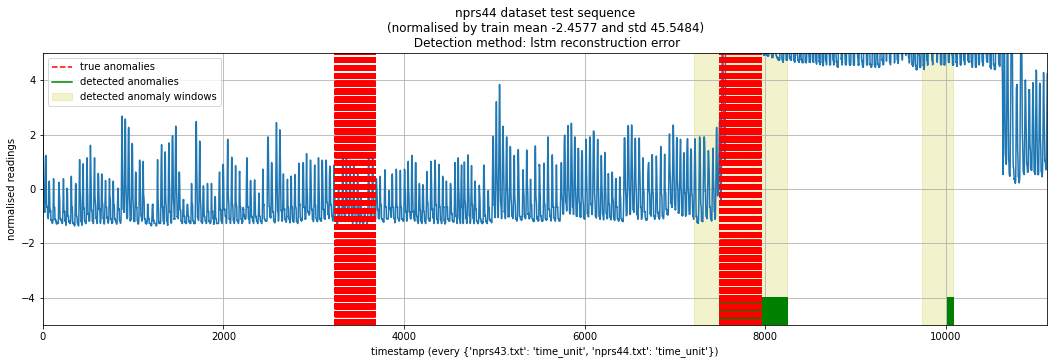

In [33]:
plot_detected_anomalies(idx_detection_augmented, 
                        interval=config['l_win']*config['l_seq']/2, 
                        dataset=dataset, 
                        result=result, 
                        detection_method='lstm reconstruction error',
                        augmented_flag=1,
                        y_scale=5,
                        y_lim=5)

In [34]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

#X_train =
#predicted_train =
#X_test = 
#predicted = 
y_test1 = np.where(test_labels_lstm==1,-1,1) #doi lai label

#OCSVM
#e=X_train - predicted_train
#e = val_lstm_error_original
e = train_lstm_error_original
nsamples, nx, ny = e.shape
d2_e = e.reshape((nsamples,nx*ny))

nu = 0.5 #0.0055
gamma = 'auto' #1.5
from sklearn import svm
clf = svm.OneClassSVM(nu=nu, kernel="rbf", gamma=gamma)
clf.fit(d2_e)

#e_t=X_test - predicted
e_t = test_lstm_error_original
nsamples, nx, ny = e_t.shape

d2_e_t = e_t.reshape((nsamples,nx*ny))
y_scores = clf.predict(d2_e_t)

precision = precision_score(y_test1, y_scores, pos_label=-1)
recall    = recall_score(y_test1, y_scores, pos_label=-1)
accuracy = accuracy_score(y_test1, y_scores)
f1 = f1_score(y_test1, y_scores, pos_label=-1)
print ('OSCVM recons abs: ')
print ('Precision : ', precision)
print ('Recall: ', recall)
print ('F1_score: ', f1)
print ('Accuracy : ', accuracy)


OSCVM recons abs: 
Precision :  0.10827621223660827
Recall:  0.579483695652174
F1_score:  0.18245989304812835
Accuracy :  0.2948339483394834


In [35]:
result['test'].shape


(11127,)

In [36]:
a = [1, 1, -1, -1]
b = [1, -1, 1, 1]
precision = precision_score(a,b,pos_label=-1)
recall = recall_score(a,b,pos_label=-1)
print(precision)
print(recall)
f1 = f1_score(a, b, pos_label=-1)
print(f1)

0.0
0.0
0.0


In [37]:
[1,3,4] + [1,7,8]

[1, 3, 4, 1, 7, 8]